In [36]:
import tensorflow as tf
import tensorflow.keras as keras
import librosa
import librosa.feature
import glob
import os
import numpy as np
from utils import load_data
from models import simple_cnn
from models import crnn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


## Loading data

In [2]:
trainX, trainY, validationX, validationY, testX, testY = load_data(split_into_k_equal_parts=True, k=6)

In [14]:
#Transposing to (batch_size, time_dimension, features) for crnn
#trainX = trainX.transpose(0,2,1)
#validationX = validationX.transpose(0,2,1)
#testX = testX.transpose(0,2,1)

#Reshaping into (batch_size, height, width, channels) for cnn

trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], trainX.shape[2], 1))
validationX = validationX.reshape((validationX.shape[0], validationX.shape[1], validationX.shape[2], 1))
testX = testX.reshape((testX.shape[0], testX.shape[1], testX.shape[2], 1))



In [15]:
print(trainX.shape)
print(trainY.shape)
print(validationX.shape)
print(testY.shape)

(90192, 128, 53, 1)
(90192, 5)
(10854, 128, 53, 1)
(10350, 5)


## Basic CNN

In [16]:
indim_x = trainX.shape[1]
indim_y = trainX.shape[2]
indim_x

128

In [27]:
model = simple_cnn((indim_x,indim_y), conv_layers=[16, 32,48], reg_rate=0.2)

In [29]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 51, 16)       160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 25, 16)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 63, 25, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 23, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 11, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 30, 11, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 9, 48)        

In [20]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="saved_weights/model.{epoch:02d}-{val_loss:.2f}.h5",
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(trainX, trainY, batch_size = 128, validation_data=(validationX, validationY), epochs=25, callbacks=[model_checkpoint_callback])

Train on 90192 samples, validate on 10854 samples
Epoch 1/25
90192/90192 [==============================] - 17s 192us/sample - loss: 0.9077 - accuracy: 0.6559 - val_loss: 0.9537 - val_accuracy: 0.6292
Epoch 2/25
90192/90192 [==============================] - 18s 195us/sample - loss: 0.8297 - accuracy: 0.6881 - val_loss: 0.9034 - val_accuracy: 0.6507
Epoch 3/25
90192/90192 [==============================] - 17s 190us/sample - loss: 0.7931 - accuracy: 0.7003 - val_loss: 0.9353 - val_accuracy: 0.6507
Epoch 4/25
90192/90192 [==============================] - 17s 190us/sample - loss: 0.7676 - accuracy: 0.7102 - val_loss: 0.9430 - val_accuracy: 0.6622
Epoch 5/25
90192/90192 [==============================] - 17s 185us/sample - loss: 0.7451 - accuracy: 0.7168 - val_loss: 0.8935 - val_accuracy: 0.6778
Epoch 6/25
90192/90192 [==============================] - 17s 185us/sample - loss: 0.7310 - accuracy: 0.7230 - val_loss: 0.8961 - val_accuracy: 0.6692
Epoch 7/25
90192/90192 [====================

In [30]:
model.load_weights("saved_weights/model.15-0.87.h5")
model.evaluate(testX, testY, verbose=2)

10350/1 - 1s - loss: 0.6430 - accuracy: 0.7320


[0.7562958026738559, 0.7319807]

In [31]:
Y_Predicted = model.predict_classes(testX, verbose=0)

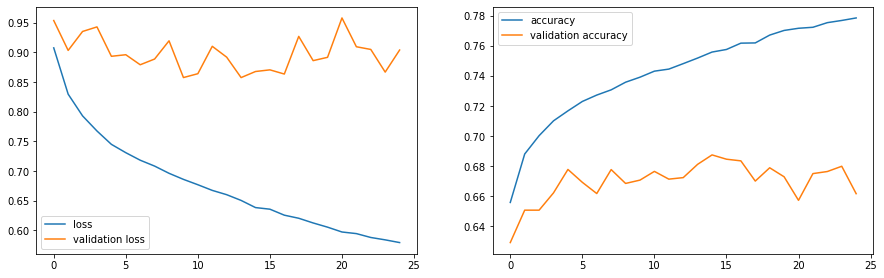

In [32]:
f = plt.figure(figsize=(15,10))
plt.subplot(221)
loss,  = plt.plot(history.history['loss'])
val_loss, = plt.plot(history.history['val_loss'])
plt.legend([loss, val_loss], ['loss', 'validation loss'])
plt.subplot(222)
acc,  = plt.plot(history.history['accuracy'])
val_acc,  = plt.plot(history.history['val_accuracy'])
plt.legend([loss, val_loss], ['accuracy', 'validation accuracy'])

In [33]:
Y_True = []
for i in testY:
    Y_True.append(list(i).index(1))

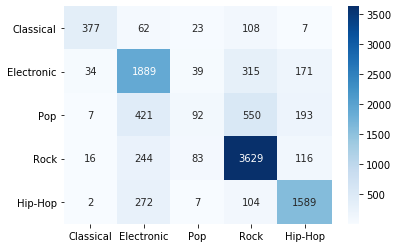

In [34]:
target_names = ['Classical', 'Electronic', 'Pop', 'Rock', 'Hip-Hop']
conf_matrix = pd.DataFrame(confusion_matrix(Y_True, Y_Predicted), index = target_names, columns = target_names)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')


In [35]:
classification = pd.DataFrame(classification_report(Y_True, Y_Predicted,target_names=target_names, output_dict = True)).transpose()
classification

,precision,recall,f1-score,support
Classical,0.864679,0.653380,0.744324,577.000000
Electronic,0.654086,0.771650,0.708021,2448.000000
Pop,0.377049,0.072842,0.122097,1263.000000
Rock,0.771143,0.887720,0.825335,4088.000000
Hip-Hop,0.765414,0.804965,0.784691,1974.000000
accuracy,0.731981,0.731981,0.731981,0.731981
macro avg,0.686474,0.638111,0.636894,10350.000000
weighted avg,0.699488,0.731981,0.699504,10350.000000


In [96]:
classification.to_csv("results_cnn.csv")
conf_matrix.to_csv("conf_matrix_cnn.csv")